<a href="https://colab.research.google.com/github/AdrianCPC/Robot_trading_DS/blob/main/Robot_Trading_DS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1 .Configuración del ambiente

In [1]:
#Determinacion de versiones disponibles para trabajar en el notebook
!python -V
print('------')
!pip show Pandas | grep 'Name\|Version'
print('------')
!pip show Numpy | grep 'Name\|Version'
print('------')
!pip show Matplotlib | grep 'Name\|Version'

Python 3.10.12
------
Name: pandas
Version: 1.5.3
------
Name: numpy
Version: 1.23.5
------
Name: matplotlib
Version: 3.7.1


##Importacion de bibliotecas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests
from IPython.display import clear_output
import time

##Variables Globales

In [3]:
global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision

##Datos Historicos del Bitcoin

In [4]:
#extrayendo datos historicos de coindesk

url = 'https://api.coindesk.com/v1/bpi/historical/close.json?start=2022-01-10&end=2023-01-10'

response = pd.read_json(url)

df = pd.DataFrame(response['bpi']).rename(columns={'bpi':'price'})
df.index = pd.to_datetime(df.index, errors='coerce')
df = df.dropna()



In [5]:
df.head(-1)

price
2022-01-10  41838.4617
2022-01-11  42744.2900
2022-01-12  43921.2833
2022-01-13  42577.1583
2022-01-14  43095.5250
...                ...
2022-07-02  19188.5217
2022-07-03  19115.5200
2022-07-04  19129.0000
2022-07-05  20205.6075
2022-07-06  19930.8450

[152 rows x 1 columns]

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_0, *['price'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_1, *['price'], **{})
chart

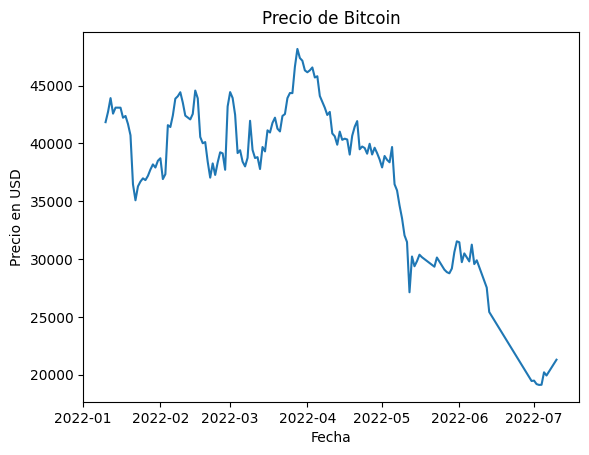

In [6]:
# Grafica de los historicos


import matplotlib.pyplot as plt

plt.plot(df)
plt.title('Precio de Bitcoin')
plt.xlabel('Fecha')
plt.ylabel('Precio en USD')
plt.show()

#2. Obtención de datos

In [21]:

#Extracción de datos historicos de precios del bitcoin en dolares BTC-USD(7 días - intervaloes de 5 minnutos)
def importar_base_bitcoin():
  global df_bitcoin

  symbol = "BTC-USD"
  date_start = pd.Timestamp.now() - pd.DateOffset(days=7)
  date_end = pd.Timestamp.now()


  df_bitcoin = yf.download(symbol, start=date_start, end=date_end, interval="5m")


In [22]:
importar_base_bitcoin()

[*********************100%%**********************]  1 of 1 completed


In [23]:
df_bitcoin.head(-1)

Open          High           Low  \
Datetime                                                              
2023-08-13 22:25:00+00:00  29316.822266  29339.738281  29313.308594   
2023-08-13 22:30:00+00:00  29335.373047  29335.373047  29330.443359   
2023-08-13 22:35:00+00:00  29327.591797  29327.591797  29286.640625   
2023-08-13 22:40:00+00:00  29287.064453  29302.253906  29265.806641   
2023-08-13 22:45:00+00:00  29296.363281  29314.734375  29293.041016   
...                                 ...           ...           ...   
2023-08-20 21:55:00+00:00  26184.251953  26184.251953  26167.384766   
2023-08-20 22:00:00+00:00  26176.138672  26194.005859  26176.138672   
2023-08-20 22:05:00+00:00  26195.763672  26199.783203  26193.917969   
2023-08-20 22:10:00+00:00  26206.455078  26206.455078  26193.222656   
2023-08-20 22:15:00+00:00  26195.138672  26195.138672  26184.431641   

                                  Close     Adj Close    Volume  
Datetime                                                         
2023-08-13 22:25:00+00:00  29339.738281  29339.738281         0  
2023-08-13 22:30:00+00:00  29330.443359  29330.443359  32109056  
2023-08-13 22:35:00+00:00  29286.640625  29286.640625  35851776  
2023-08-13 22:40:00+00:00  29299.744141  29299.744141  82938368  
2023-08-13 22:45:00+00:00  29307.863281  29307.863281  27937792  
...                                 ...           ...       ...  
2023-08-20 21:55:00+00:00  26167.847656  26167.847656  18372608  
2023-08-20 22:00:00+00:00  26194.005859  26194.005859         0  
2023-08-20 22:05:00+00:00  26199.783203  26199.783203   6267904  
2023-08-20 22:10:00+00:00  26193.222656  26193.222656  18496512  
2023-08-20 22:15:00+00:00  26190.375000  26190.375000  34880512  

[2015 rows x 6 columns]

In [39]:
#Extraccion del precio actual del BTC y variacion del precio en la ultima hora usando Web Scraping
def extraer_tendencias():
  global precio_actual, tendencia

  url = "https://coinmarketcap.com/"
  response = requests.get(url)
  soup = BeautifulSoup(response.content, "html.parser")


  #Busqueda de precio actual BTC
  precio_actual_element = soup.find("div", class_="sc-aef7b723-0 sc-4aa55ad0-0 jnFPdV coin-stats")
  precio_actual_text = precio_actual_element.text.strip()
  precio_actual = float(precio_actual_text.replace("$", "").replace(",", ""))

  #Variacion precio ultima hora
  variacion_1h_element = soup.find("span", text="1h")
  variacion_1h_parent = variacion_1h_element.find_parent("div", class_="sc-15yy2pl-0 cPmGKC priceChange___3Hie7")
  variacion_1h_text = variacion_1h_parent.find("span").text.strip()
  variacion_1h = float(variacion_1h_text.replace("%", ""))

  precio_actual = float(precio_actual_text.replace("$", "").replace(",", ""))
  tendencia = "baja" if variacion_1h < 0 else "alta"

  #Tendencias
  tendencia = "baja" if variacion_1h < 0 else "alta"


In [40]:
  def main():
    global precio_actual, tendencia

    extraer_tendencias()


In [41]:
print("Precio Actual del Bitcoin:", precio_actual)
print("Tendencia:", tendencia)

NameError: ignored

In [42]:
if __name__ == "__main__":
    main()

AttributeError: ignored

#3. Limpieza de datos

#4. Tomar decisiones

#5. Visualización

#6. Automatización